# Phase 5: SHAP Analysis of CatBoost for $t=2$

## Setup

In [13]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
import random
seed_val = 43
np.random.seed(seed_val)
random.seed(seed_val)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data Loading

Load the test-set

In [14]:
seed = 42
train_set = pd.read_csv(f"datasets/train_set_{seed}_t_2.csv")
test_set = pd.read_csv(f"datasets/test_set_{seed}_t_2.csv")

In [15]:
X_train = train_set.drop(['is_drop'], axis=1)
y_train = train_set['is_drop'].copy()

In [16]:
X_display = test_set.drop(['is_drop'], axis=1)
y_test = test_set['is_drop'].copy()

In [17]:
X_display.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6363 entries, 0 to 6362
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index_o            6363 non-null   int64  
 1   year               6363 non-null   int64  
 2   semester           6363 non-null   int64  
 3   grade              6363 non-null   int64  
 4   sex                6363 non-null   object 
 5   gpa_last_seme      6363 non-null   float64
 6   credits_last_seme  6363 non-null   float64
 7   credits_tot        6363 non-null   float64
 8   n_seme             6363 non-null   int64  
 9   years_since        6363 non-null   int64  
 10  college            6363 non-null   object 
 11  adm_unit           6363 non-null   int64  
 12  nation             6363 non-null   int64  
 13  in_capa            6363 non-null   bool   
 14  leave              6363 non-null   bool   
dtypes: bool(2), float64(3), int64(8), object(2)
memory usage: 658.8+ KB


## Data Transformation

In [18]:
# Label encoding for categorical features
def sex_mapping(sex):
    sex_map = {'M': 0, 'F': 1}
    return sex_map[sex]

def seme_mapping(seme):
    seme_map = {1: 0, 2: 1}
    return seme_map[seme]

def college_mapping(college):
    college_map = {'TH': 0, 'HS': 1, 'BZ': 2, 'HT': 3, 'EG': 4, 'SW': 5, 'AT': 6}
    return college_map[college]


In [19]:
# Label encoding for categrical features
def label_encoding(data):
    data_x = data.copy()
    data_x['sex'] = data['sex'].map(sex_mapping)
    data_x['semester'] = data['semester'].map(seme_mapping)
    data_x['college'] = data['college'].map(college_mapping)
    return data_x

In [20]:
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attrs = ['grade', 'gpa_last_seme', 'credits_last_seme', 'credits_tot', 'n_seme', 'years_since']
cat_attrs = ['semester', 'sex', 'adm_unit', 'nation', 'in_capa', 'college', 'leave']

full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attrs),
    ('cat', OneHotEncoder(), cat_attrs)
])

cat_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attrs),
    ('cat', 'passthrough', cat_attrs)
])

label_encoding(X_train)
X_train = cat_pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cat_pipeline.get_feature_names_out())

X_test = label_encoding(X_display)
X_test = cat_pipeline.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cat_pipeline.get_feature_names_out())

cat_indices = [6, 7, 8, 9, 10, 11, 12]


In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6363 entries, 0 to 6362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   num__grade              6363 non-null   object
 1   num__gpa_last_seme      6363 non-null   object
 2   num__credits_last_seme  6363 non-null   object
 3   num__credits_tot        6363 non-null   object
 4   num__n_seme             6363 non-null   object
 5   num__years_since        6363 non-null   object
 6   cat__semester           6363 non-null   object
 7   cat__sex                6363 non-null   object
 8   cat__adm_unit           6363 non-null   object
 9   cat__nation             6363 non-null   object
 10  cat__in_capa            6363 non-null   object
 11  cat__college            6363 non-null   object
 12  cat__leave              6363 non-null   object
dtypes: object(13)
memory usage: 646.4+ KB


In [22]:
X_test.rename(columns={'num__grade': 'year', 'num__gpa_last_seme': 'gpa_last', 'num__credits_last_seme': 'credits_last',
                       'num__credits_tot': 'credits_tot', 'num__n_seme': 'n_semesters', 'num__years_since': 'years_since',
                       'cat__semester': 'release', 'cat__sex': 'sex', 'cat__adm_unit': 'adm_type', 'cat__nation': 'nation',
                       'cat__in_capa': 'in_capa', 'cat__college': 'college', 'cat__leave': 'status'}, inplace=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6363 entries, 0 to 6362
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          6363 non-null   object
 1   gpa_last      6363 non-null   object
 2   credits_last  6363 non-null   object
 3   credits_tot   6363 non-null   object
 4   n_semesters   6363 non-null   object
 5   years_since   6363 non-null   object
 6   release       6363 non-null   object
 7   sex           6363 non-null   object
 8   adm_type      6363 non-null   object
 9   nation        6363 non-null   object
 10  in_capa       6363 non-null   object
 11  college       6363 non-null   object
 12  status        6363 non-null   object
dtypes: object(13)
memory usage: 646.4+ KB


In [23]:
X_test.head()

,year,gpa_last,credits_last,credits_tot,n_semesters,years_since,release,sex,adm_type,nation,in_capa,college,status
0,1.182633,-0.550018,0.456981,1.852454,1.727313,2.179576,0,0,4,0,True,1,False
1,1.182633,0.592616,-0.033164,1.423536,1.285138,1.12229,1,0,1,0,True,4,False
2,-1.746586,-0.851118,-1.013453,-1.766536,-1.367913,-1.520926,1,0,3,0,True,4,False
3,-1.746586,0.909156,-0.033164,-1.337619,-1.367913,-1.520926,1,0,0,0,True,5,False
4,1.182633,-0.650385,-0.033164,1.235885,1.285138,1.12229,1,0,1,0,True,4,False


In [24]:
X_display.drop(['year'], axis=1, inplace=True)
X_display.rename(columns={'grade': 'year', 'gpa_last_seme': 'gpa_last', 'credits_last_seme': 'credits_last',
                       'n_seme': 'n_semesters', 'semester': 'release', 'adm_unit': 'adm_type', 'leave': 'status'}, inplace=True)
X_display = X_display[['year', 'gpa_last', 'credits_last', 'credits_tot', 'n_semesters', 'years_since', 'release', 'sex',
                       'adm_type', 'nation', 'in_capa', 'college', 'status']]

release_mapping = {1: 'Spring', 2: 'Fall'}
sex_mapping = {'M': 'Male', 'F': 'Female'}
status_mapping = {False: 'Enrolled', True: 'On leave'}

X_display['release'] = X_display['release'].map(release_mapping)
X_display['sex'] = X_display['sex'].map(sex_mapping)
X_display['status'] = X_display['status'].map(status_mapping)

In [25]:
X_display.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6363 entries, 0 to 6362
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          6363 non-null   int64  
 1   gpa_last      6363 non-null   float64
 2   credits_last  6363 non-null   float64
 3   credits_tot   6363 non-null   float64
 4   n_semesters   6363 non-null   int64  
 5   years_since   6363 non-null   int64  
 6   release       6363 non-null   object 
 7   sex           6363 non-null   object 
 8   adm_type      6363 non-null   int64  
 9   nation        6363 non-null   int64  
 10  in_capa       6363 non-null   bool   
 11  college       6363 non-null   object 
 12  status        6363 non-null   object 
dtypes: bool(1), float64(3), int64(5), object(4)
memory usage: 602.9+ KB


Load the baseline CatBoost for $t=2$.

In [26]:
import joblib

loaded_model = joblib.load(f'models/base_cat_1_2.pkl')
cat_clf = loaded_model['model']

## SHAP Analysis on Test-set.

In [27]:
import shap

explainer = shap.TreeExplainer(cat_clf)
shap.initjs()
shap_values = explainer(X_test)


c:\Users\jin\OneDrive\data_sci\college-dropout\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
shap_values.display_data = X_display.values

In [29]:

plt.rcParams.update({
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

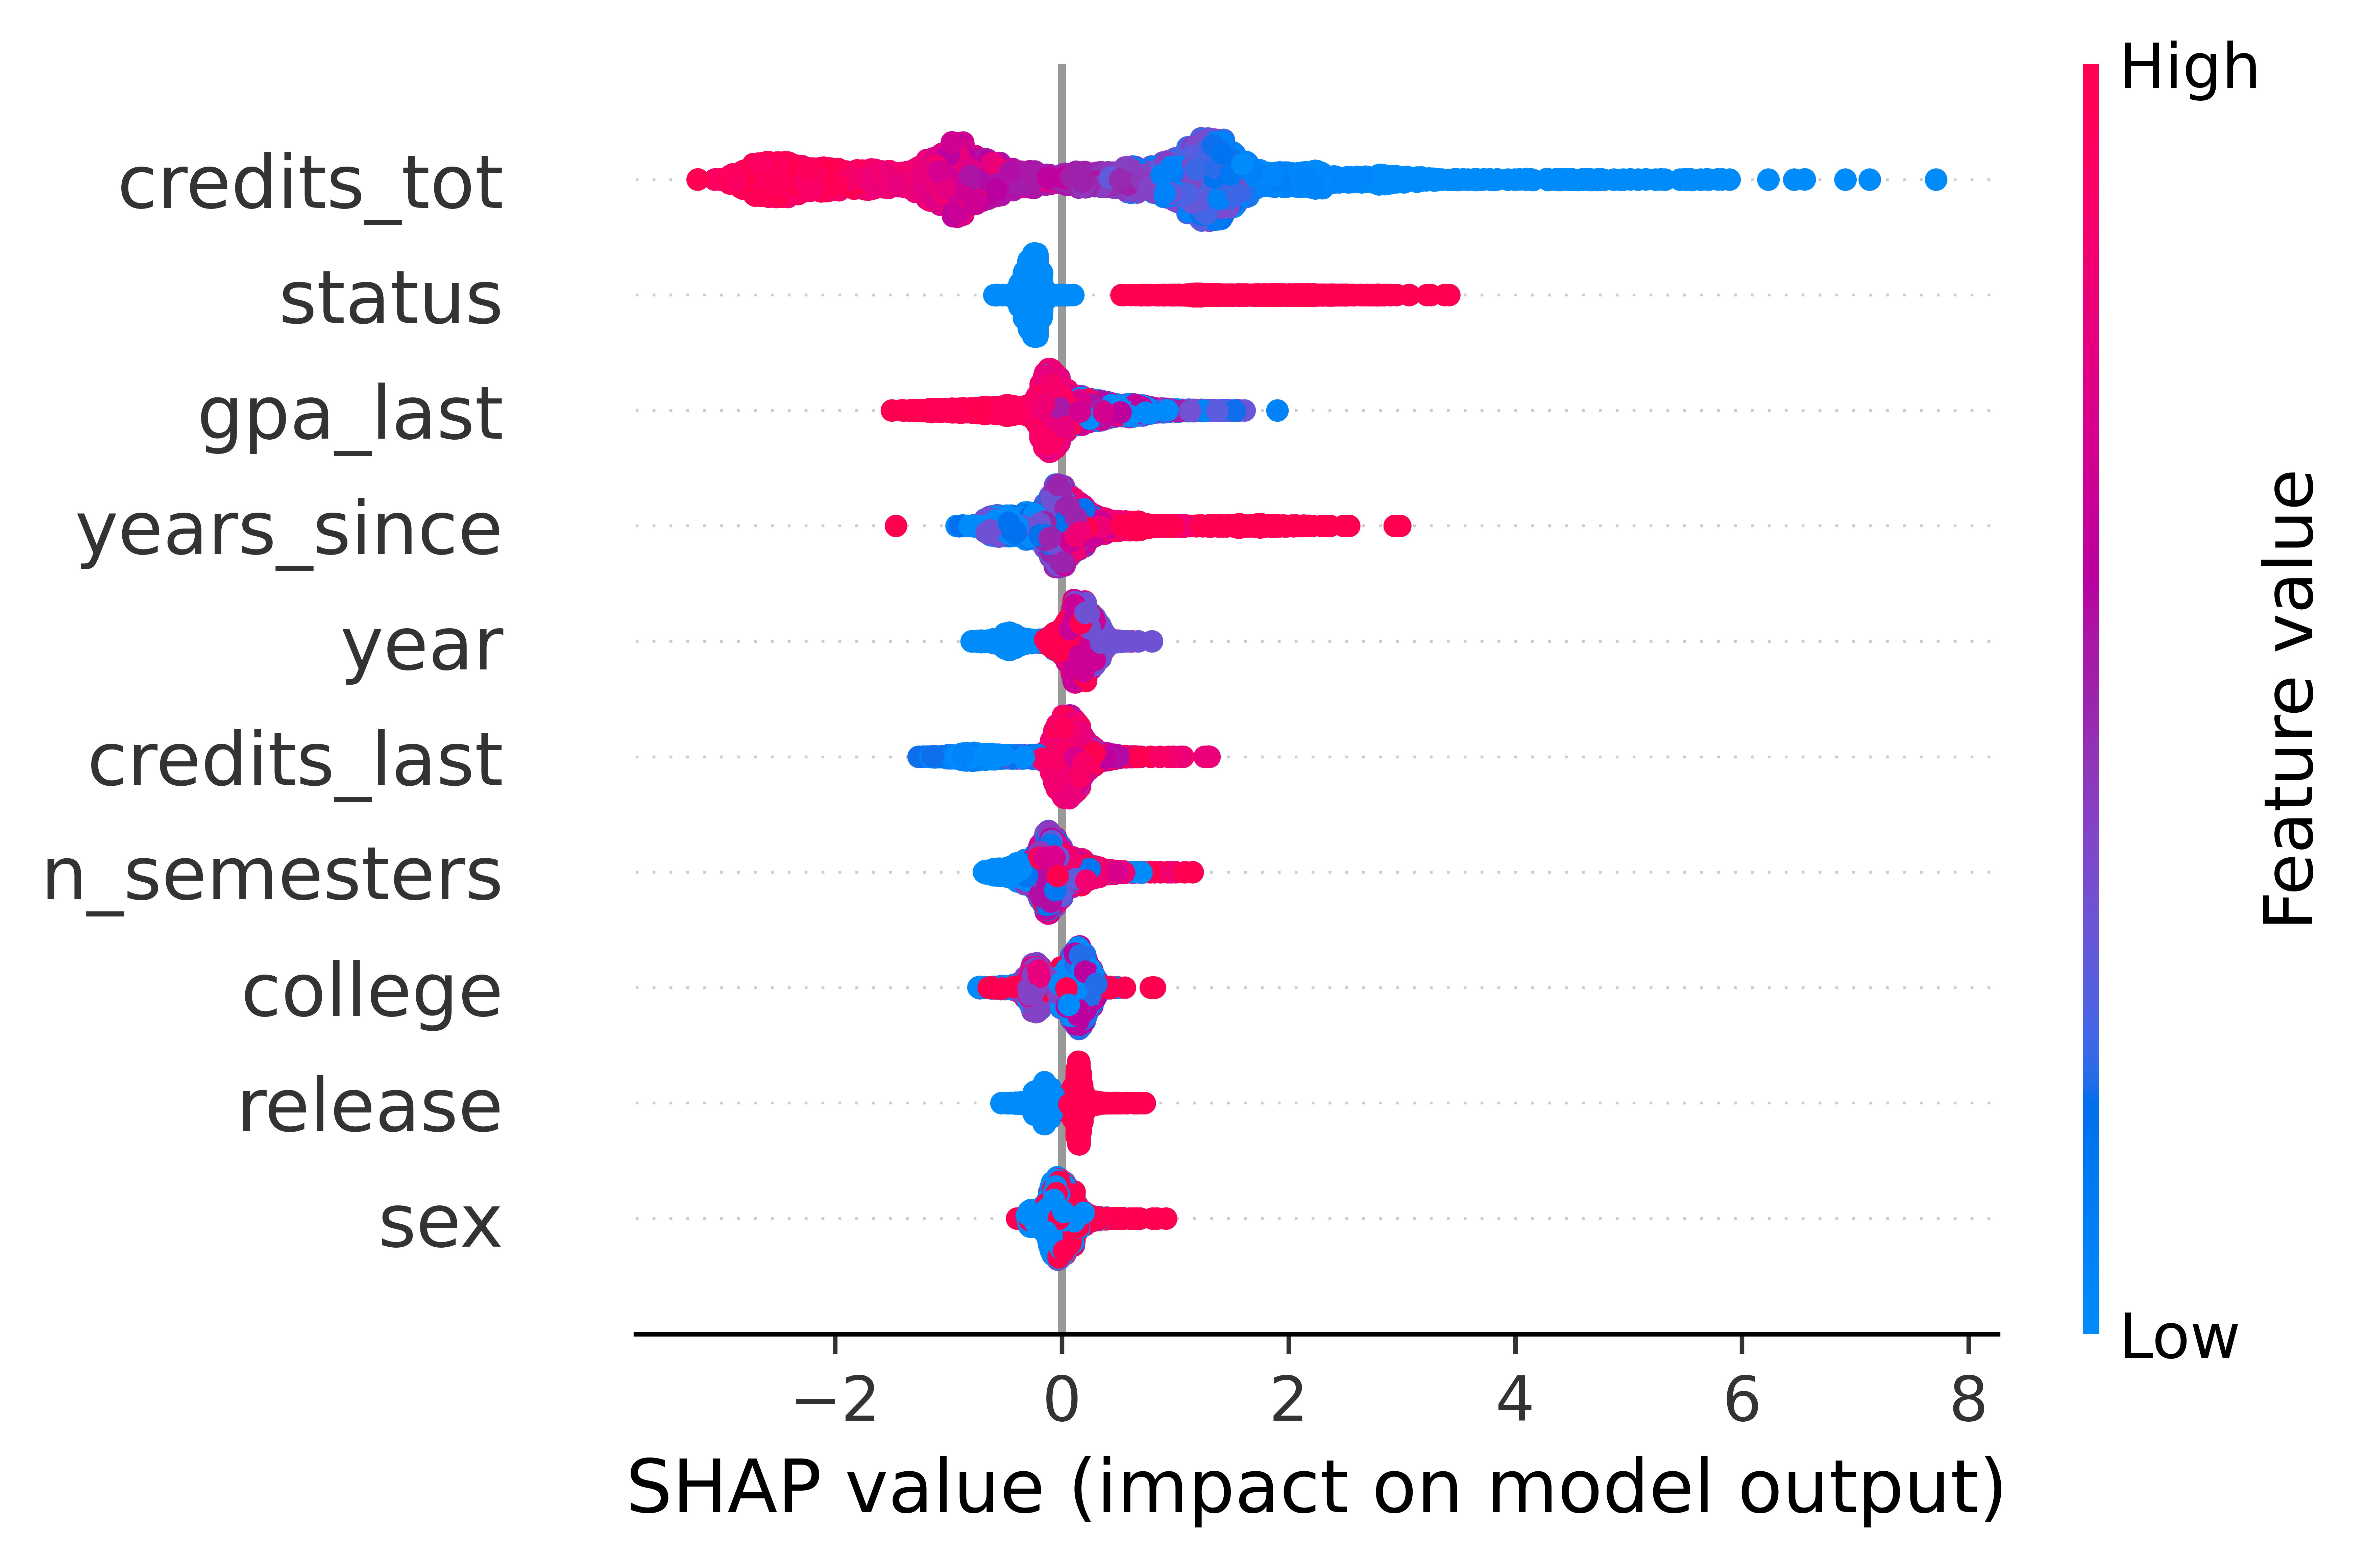

In [30]:
plt.figure(figsize=(6,4), dpi=1200)
shap.summary_plot(shap_values, max_display=10, show=False)

fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.tight_layout(pad=1.2, w_pad=0.5, h_pad=0.5)

plt.savefig('figs/shap_summary.jpg', dpi=1200)


<Figure size 7200x4800 with 0 Axes>

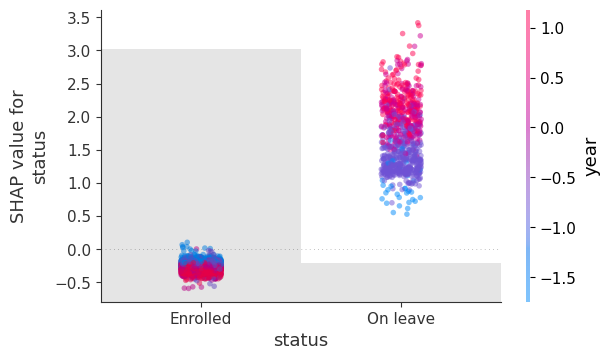

In [31]:
plt.figure(figsize=(6,4), dpi=1200)
shap.plots.scatter(shap_values[:, 'status'], 
                   color=shap_values[:, 'year'], # 'cat__sex', 'num__grade
                   alpha=0.5, show=False)

fig = plt.gcf()
plt.tight_layout(pad=1.2, w_pad=1, h_pad=1)
fig.set_size_inches(6, 4)
#plt.tight_layout(pad=0.8)

plt.xticks(rotation=0)
plt.savefig('figs/shap_status.jpg', dpi=1200)

<Figure size 7200x4800 with 0 Axes>

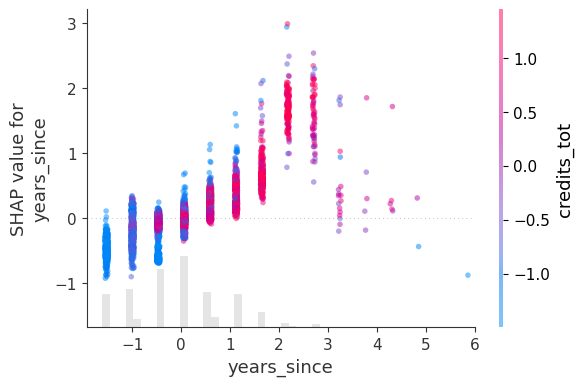

In [32]:
plt.figure(figsize=(6,4), dpi=1200)
shap.plots.scatter(shap_values[:, 'years_since'], 
                   color=shap_values[:, 'credits_tot'],
                   alpha=0.5, xmax=6, show=False)
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.tight_layout(pad=1.2, w_pad=0.5, h_pad=0.5)

plt.savefig('figs/shap_years_since.jpg', dpi=1200)

<Figure size 7200x4800 with 0 Axes>

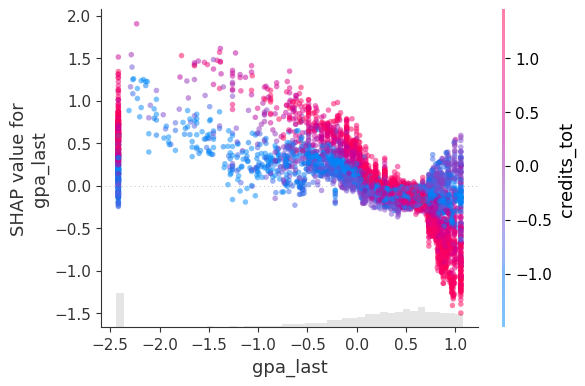

In [33]:
plt.figure(figsize=(6,4), dpi=1200)
shap.plots.scatter(shap_values[:, 'gpa_last'], 
                   color=shap_values[:, 'credits_tot'], # num__years_since, cat__leave
                   alpha=0.5, show=False)
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.tight_layout(pad=1.2, w_pad=0.5, h_pad=0.5)

plt.savefig('figs/shap_gpa_last.jpg', dpi=1200)